### Configure jupyter in Pycharm
http://zhuangzhuang.github.io/2017/01/22/fix-pycharm-jupyter/

In [1]:
import pandas as pd
import sqlite3
import numpy
import os
os.chdir("/Users/joecao/Documents/Upenn/Courses/CIS520/cis520project")  # change root directory

### Notes
    √ missing value checked   
        * amdRaw_df.isnull().any()  
        * googleRaw_df.isnull().any()   
    √ Transfer Date column into datetime type  
    ❗Create Features by indicators   
    ⭕❌❓

In [27]:

amd_raw_df=pd.read_csv('raw_data_amdgoogle/AMD.csv')
google_raw_df=pd.read_csv('raw_data_amdgoogle/GOOGL.csv')
amd_raw_df.columns=['date','open','high','low','close','adj_close','volume']
google_raw_df.columns=['date','open','high','low','close','adj_close','volume']
amd_raw_df['date']=pd.to_datetime(amd_raw_df['date'],format='%Y-%m-%d')
google_raw_df['date']=pd.to_datetime(google_raw_df['date'],format='%Y-%m-%d')

In [28]:
engine = sqlite3.connect('stock_price_DB')
amd_raw_df.to_sql('amd_raw',con=engine,if_exists='replace',index=False)
google_raw_df.to_sql('google_raw',con=engine,if_exists='replace',index=False)

  * Middle Band = 20-day simple moving average (SMA)
  * Upper Band = 20-day SMA + (20-day standard deviation of price x 2) 
  * Lower Band = 20-day SMA - (20-day standard deviation of price x 2)

In [53]:
def create_features(df):
    df['middle_band']=df['adj_close'].rolling(window=20).mean()
    stdv=df['adj_close'].rolling(window=20).std()  # 20-day standard deviation
    df['upper_band']=df['middle_band']+stdv*2
    df['lower_band']=df['middle_band']-stdv*2   #20 days
    
    return df

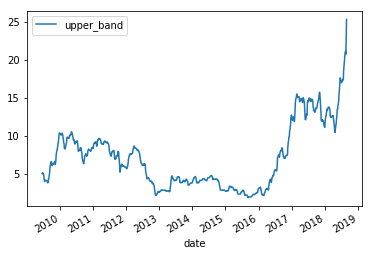

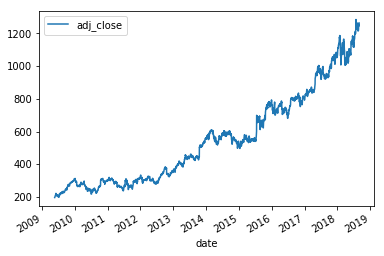

In [65]:
amd_df=create_features(amd_raw_df)
google_df=create_features(google_raw_df)
amd_df.plot(x='date', y='upper_band')
google_df.plot(x='date', y='adj_close')

In [67]:
google_df.head()

,date,open,high,low,close,adj_close,volume,middle_band,upper_band,lower_band
0,2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700,NaN,NaN,NaN
1,2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700,NaN,NaN,NaN
2,2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500,NaN,NaN,NaN
3,2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200,NaN,NaN,NaN
4,2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100,NaN,NaN,NaN
